## Segmentation

<p style='direction:rtl; text-align: right'>
در این مسأله برای قطعه بندی، ابتدا حداقل یک پیکسل داخل یک پرنده را ورودی میگیریم و سپس قطعه‌های مشابه را به عنوان پرنده
اعلام می‌کنیم.
<br><br>
برای قطعه‌بندی ابتدایی از روش Felzenswalb استفاده میکنیم و پارامتر های آن را به گونه‌ای تعیین می‌کنیم
که Over-Segmentation یا Under-Segmentation رخ ندهد. بعلاوه پیش از شروع، یک فیلتر گوسی برای کاهش تاثیر نویز اعمال می‌کنیم.
پس از آن می‌توان قطعه‌ی پرنده‌ی پیکسل داده‌شده را پیدا کرد و ویژگی‌های تکسچر آن را استخراج کرد و
قطعه‌های دیگری که تکسچر مشابهی دارند را انتخاب کرد.
<br><br>
برای استخراج ویژگی‌های یک تکسچر، از ویژگی‌های متفاوتی استفاده میکنیم.
از توزیع مقادیر H,S در فضای رنگی HSV استفاده میکنیم که نسبتن به روشنایی ناورداست و رنگ تکسچر را توصیف می‌کند.
از توزیع LBP نقاط(Local Binary Pattern) استفاده می‌کنیم که می‌تواند ناهمواری‌های تکسچر را توصیف کند. همچنین LBP نقاط را
دسته‌بندی می‌کنیم تا الگو‌های مشابه در یک دسته قرار‌گیرند و نسبت به چرخش ناوردا باشند.
از aspect-ratio قطعات نیز استفاده می‌کنیم. پرنده‌ها موجوداتی هستند که در یک فضای نسبتن مربعی جای‌ میگیرند و نمی‌توانند
برای مثال شکل کشیده‌ای داشته باشند.
<br><br>
حال ویژگی‌های گفته شده را با وزن مناسب در یک بردار قرار می‌دهیم. برای مقایسه بردارها از فاصله Chi-square استفاده می‌کنیم
که تست خوبی برای مطابقت است.
<br><br>
در نهایت روی سگمنت‌های به دست آمده opening و dilation اعمال میکنیم تا خطاهای قطعه‌بندی کمتر شود و شکل طبیعی‌تری به دست‌آید.
</p>


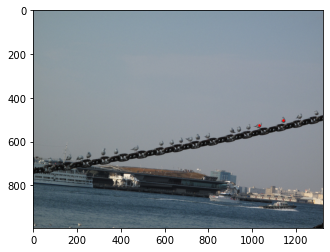

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import color as skcolor
from skimage import feature, segmentation
from skimage import morphology as mph
import cv2 as cv

ratio = 0.3
img_o = plt.imread('./data/birds.jpg')
img_r = cv.resize(img_o, (0, 0), img_o, ratio, ratio)

plt.imshow(img_r)
bird_pt = (np.array([[1670, 3800], [1750, 3440]]) * ratio).astype(int)
plt.scatter(bird_pt[:, 1], bird_pt[:, 0], s=2, c='red')
plt.show()

<p style='direction:rtl; text-align: right'>
در شکل بالا پیسکل‌های نمونه با رنگ قرمز مشخص شده‌اند.
حال قطعه‌بندی را روی شکل اعممال می‌کنیم:
</p>

In [2]:
img = img_r.copy()
segments_fz = segmentation.felzenszwalb(img, scale=350, sigma=0.5, min_size=250)

c_seg = segments_fz.max()
print(f"Felzenszwalb number of segments: {c_seg}")

print('segments of the two sample:', segments_fz[tuple(bird_pt[0])], segments_fz[tuple(bird_pt[1])])

Felzenszwalb number of segments: 117
segments of the two sample: 5 8


<p style='direction:rtl; text-align: right'>
قطعه‌بندی را با رنگ‌های تصادفی نمایش می‌دهیم:
</p>

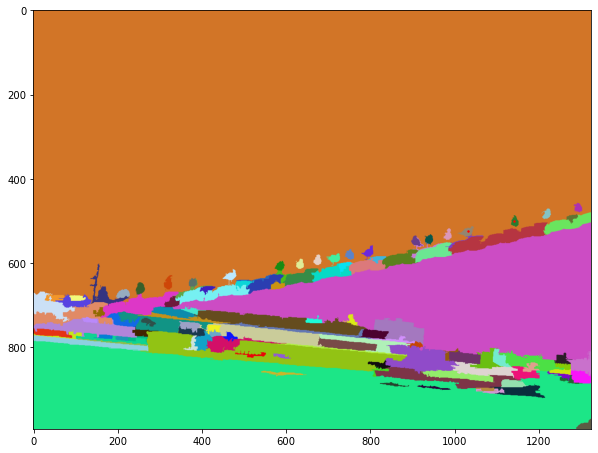

In [3]:
label_image = np.zeros_like(img)
for t in np.unique(segments_fz):
    label_image[segments_fz == t] = np.random.randint(0, 255, 3)
plt.figure(figsize=(10, 10))
plt.imshow(label_image)
plt.scatter(bird_pt[:, 1], bird_pt[:, 0], s=2, c='red')
plt.show()

<p style='direction:rtl; text-align: right'>
در شکل زیر می‌توانید مقایسه هیستوگرام دو پرنده‌ی نمونه و یک سگمنت تصادفی را ببینید.
</p>

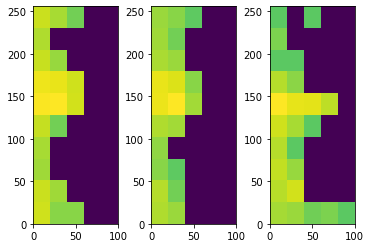

In [4]:
img_hs = cv.cvtColor(img, cv.COLOR_RGB2HSV_FULL)[..., :2]
fig, ax = plt.subplots(ncols=3, sharey='col')
for i,sg in enumerate([segments_fz[tuple(bird_pt[0])], segments_fz[tuple(bird_pt[1])], 43]):
    hist_hs, m_borders = np.histogramdd(img_hs[segments_fz == sg], bins=(10, 5),
                                        range=((0, 256), (0, 100)), density=True)
    ax[i].imshow(np.log(hist_hs + 1e-12), interpolation='nearest', origin='lower',
                 extent=[m_borders[1][0], m_borders[1][-1], m_borders[0][0], m_borders[0][-1]])
plt.show()

<p style='direction:rtl; text-align: right'>
شکل زیر، رنگ‌آمیزی تصویر با استفاده از LBP نقاط است. همانطور که می‌بینید پرنده‌ها به گونه‌ای قابل تشخیصند. پس باید
توزیع مشابهی از مشخصه‌های LBP داشته‌باشند.
<br><br>
پ.ن: LBP نسبتن دادن یک عدد به وضعیت کمتر یا بیشتر بودن یک پیکسل نسبت به اطرافیانش است. برای مثال شکل زیر را ببینید:

![LBP](https://scikit-image.org/docs/dev/_images/sphx_glr_plot_local_binary_pattern_001.png "LBP")
برای مثال در اینجا نقاط سیاه نشان‌دهنده اینتنسیتی کمتر نسبتن به مرکز و نقاط سفید نشان دهنده اینتنسیتی بیشتر هستند. و هرکدام از این وضعیت‌ها به یک دسته متناظر می‌شود.
</p>


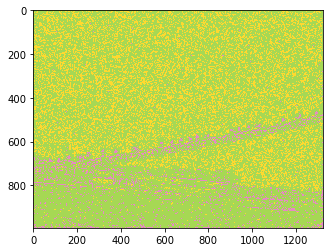

In [5]:
lbp = feature.local_binary_pattern(skcolor.rgb2gray(img), 8, 1, method='uniform').astype(int)
plt.imshow(lbp, cmap='Set2')
plt.show()

<p style='direction:rtl; text-align: right'>
در شکل زیر می‌توانید مقایسه هیستوگرام دو پرنده‌ی نمونه و یک سگمنت تصادفی را ببینید که هم‌بستگی دو سگمنت پرنده آشکار است.
</p>

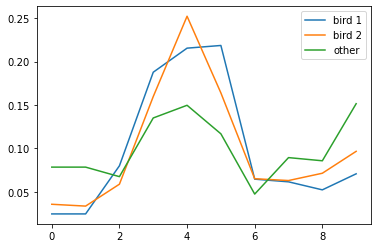

In [6]:
for sg,s in zip([segments_fz[tuple(bird_pt[0])], segments_fz[tuple(bird_pt[1])], 43],['bird 1','bird 2','other']):
    un, cn = np.unique(lbp[segments_fz == sg].ravel(), return_counts=True)
    plt.plot(un, cn/cn.sum(), label=s)
plt.legend()
plt.show()

<p style='direction:rtl; text-align: right'>
و در نهایت می‌توانید توزیع aspect-ratio برای سگمنت‌های مختلف را ببینید. خطوط قرمز نشان‌دهنده دو سگمنت پرنده است.
البته aspect-ratio به خودی خود معیار مناسبی نیست زیرا رفتار خطی ندارد و تفاوت aspect به مقدار خود آن نیز وابسته‌ است.
بنابرین قدر مطلق لگاریتم را در نظر میگیریم تا رفتار دو متغیر طول و عرض نسبت به هم خطی باشد.
</p>

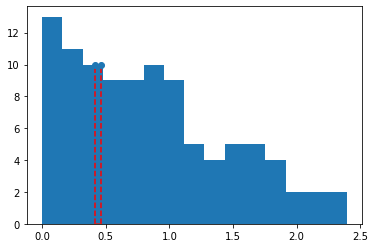

In [7]:
def get_aspect(label):
    tt = np.argwhere(segments_fz == label)
    return np.abs(np.log((tt[..., 1].min() - tt[..., 1].max()) / (tt[..., 0].min() - tt[..., 0].max())))


aspects_list = list()
for i in range(100):
    aspects_list.append(get_aspect(i))
aspects_list = np.array(aspects_list)

plt.hist(aspects_list, bins=15)
plt.stem([get_aspect(segments_fz[tuple(bird_pt[0])]), get_aspect(segments_fz[tuple(bird_pt[1])])], [10,10],linefmt='--r')
plt.show()

In [8]:
[get_aspect(segments_fz[tuple(bird_pt[0])]), get_aspect(segments_fz[tuple(bird_pt[1])])]

[0.46262352194811296, 0.41871033485818504]

<p style='direction:rtl; text-align: right'>
حال با توجه به مشاهدات بالا، بردار ویژگی را برای سگمنت‌های تصویر استخراج می‌کنیم و فواصل آن‌ها را حساب می‌کنیم.
ماتریس مجاورت سگمنت‌ها را در ادامه‌ می‌بینید. باید سعی کنیم وزن ویژگی‌ها را به گونه‌ای انتخاب کنیم که این ماتریس از یونیفرم
دور باشد و سگمنت پرنده‌ها فواصل خیلی کمتری نسبت به میانگین فواصل داشته باشند.
</p>


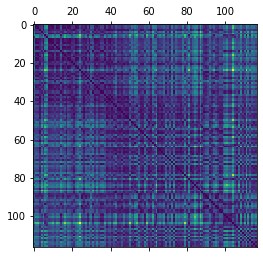

In [9]:
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV_FULL)

def get_features(label):
    ft = list()
    cond = segments_fz == label

    ft.append(np.histogramdd(img_hsv[cond][..., :2]
                             , bins=(10, 5), range=((0, 256), (0, 100))
                             , density=True)[0].ravel())

    un, cn = np.unique(lbp[cond].ravel(), return_counts=True)
    tmp = np.zeros(18)
    s = cn.sum()
    for u, c in zip(un, cn):
        tmp[u] = c / s
    ft.append(tmp)

    ft.append(get_aspect(label))

    ft.append(img_hsv[cond][2].var())
    return ft


def distance(fa, fb, weights = (10, 1.5, 0.5, 0.0002)):
    res = 0
    # chi-squared weighted average
    for i, a, b in zip(range(len(fa)), fa, fb):
        res += np.sum(((a - b) ** 2) / (a + b + 1e-12) * weights[i])
    return res


ftr_list = [get_features(i) for i in range(c_seg)]

mtt = np.zeros((c_seg, c_seg))
for i, e in np.ndenumerate(mtt):
    mtt[i] = distance(ftr_list[i[0]], ftr_list[i[1]])

plt.matshow(mtt)
plt.show()

<p style='direction:rtl; text-align: right'>
نتیجه استخراج پرنده‌ها را در ادامه می‌بینید:
</p>

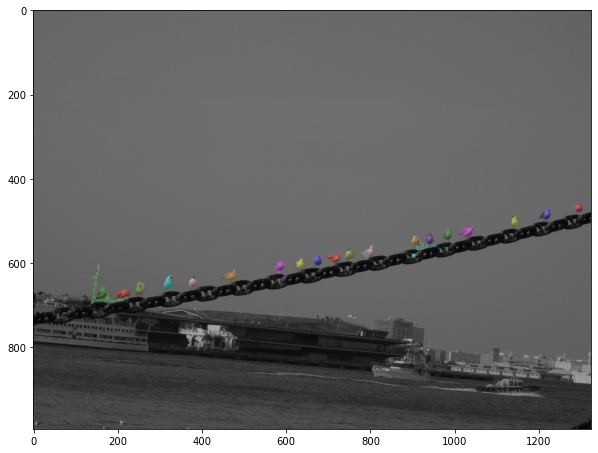

In [10]:
label_image = np.zeros(img.shape[:2])
thr = 0.22
for i in range(c_seg):
    if mtt[2, i] < thr:
        label_image[segments_fz == i] = i

img_overlay = skcolor.label2rgb(label=label_image, image=img, bg_label=0)

plt.figure(figsize=(10,10))
plt.imshow(img_overlay)
plt.show()

<p style='direction:rtl; text-align: right'>
به علت خطا‌ها و نویز های سگمنت‌بندی، سگمنت‌ها شکل یک‌دستی ندارند. برای بهبود شکل آن‌ها از عمل opening استفاده می‌کنیم
و یک dilation نیز در نهایت برای جبران کوچک‌شدن قسمت‌های باریک از دست رفته اعمال می‌کنیم.
</p>

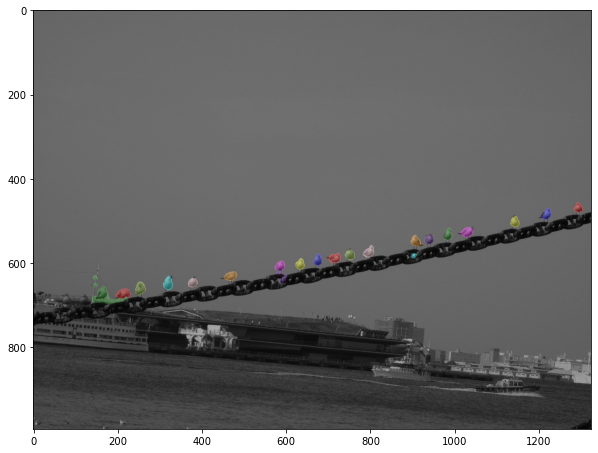

In [11]:
label_image_smoothed = np.zeros(img.shape[:2])
thr = 0.22
for i in range(c_seg):
    if mtt[2, i] < thr:
        cond = segments_fz == i
        cond = mph.opening(cond, selem=mph.disk(3))
        cond = mph.dilation(cond, selem=mph.disk(2))
        label_image_smoothed[cond] = i

img_overlay_smoothed = skcolor.label2rgb(label=label_image_smoothed, image=img, bg_label=0)

plt.figure(figsize=(10,10))
plt.imshow(img_overlay_smoothed)
plt.show()
